In [ ]:
!pip install node2vec
!pip install numba
!pip install gensim
!pip install gem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


  Preparing metadata (setup.py) ... done
  Created wheel for gem: filename=gem-0.1.12-py3-none-any.whl size=15442 sha256=f56ccb4f2fd14bd3beafb8c6c0182dde415ed10bd95ed45c304e0def100c762f
  Stored in directory: /root/.cache/pip/wheels/8b/7c/66/504c28dc3a8ce2db0dc53adef93e8fc66aedc2f493840ed99b
Successfully built gem


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gem as gem
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from node2vec import Node2Vec
import random

In [ ]:
# # Function to extract features from the graph
# def extract_features(G, node1, node2):
#     features = []
#     features.append(len(list(nx.common_neighbors(G, node1, node2))))
#     features.append(len(list(nx.all_neighbors(G, node1))))
#     features.append(len(list(nx.all_neighbors(G, node2))))
#     return features

In [ ]:
def create_hardcoded_graph():
    G = nx.Graph()

    no_of_families=2
    n=no_of_families*5

    # family_nodes1 = [i for i in range(0,5)]
    # G.add_edges_from([(i, (i + 1) % 5, {'relationship': 'family'}) for i in family_nodes1])

    # family_nodes2 = [i for i in range(5,10)]
    # G.add_edges_from([(i, (i + 1) % 5 + 5, {'relationship': 'family'}) for i in family_nodes2])

    for i in range(0,n,5):
      G.add_edges_from([(j, (j + 1) % 5+i, {'relationship': 'F'}) for j in range(i,i+5)])

    for i in range(0,n-5,5):
      G.add_edges_from([(j,  j+ 5, {'relationship': 'C'}) for j in range(i,i+4)])

    G.add_edges_from([(9,6, {'relationship': 'F'})])
    G.add_edges_from([(6,9, {'relationship': 'F'})])
    G.add_edges_from([(8,6, {'relationship': 'F'})])
    G.add_edges_from([(6,8, {'relationship': 'F'})])

    G.add_edges_from([(1, 9, {'relationship': 'N'}),
                      (1, 6, {'relationship': 'N'}),
                      (2, 7, {'relationship': 'N'})])
    return G

In [ ]:
def custom_train_test_split(G, test_size=0.2, random_state=None):
    edges = list(G.edges(data=True))

    # Separate edges based on relationship type
    family_edges = [(node1, node2, data) for node1, node2, data in edges if data['relationship'] == 'F']
    colleague_edges = [(node1, node2, data) for node1, node2, data in edges if data['relationship'] == 'C']
    non_relationship_edges = [(node1, node2, data) for node1, node2, data in edges if data['relationship'] == 'N']

    # Perform train-test split for each relationship type
    family_train, family_test = train_test_split(family_edges, test_size=test_size, random_state=random_state)
    colleague_train, colleague_test = train_test_split(colleague_edges, test_size=test_size, random_state=random_state)
    non_relationship_train, non_relationship_test = train_test_split(non_relationship_edges, test_size=test_size, random_state=random_state)

    # Concatenate the split edges to get the final train and test sets
    train_edges = family_train + colleague_train + non_relationship_train
    test_edges = family_test + colleague_test + non_relationship_test

    return train_edges, test_edges

In [ ]:
def plot_graph(G):
    pos = nx.spring_layout(G)  # Layout for node positions
    labels = nx.get_edge_attributes(G, 'relationship')

    # Separate edges based on relationship type
    family_edges = [(node1, node2) for node1, node2, data in G.edges(data=True) if data['relationship'] == 'F']
    norel_edges = [(node1, node2) for node1, node2, data in G.edges(data=True) if data['relationship'] == 'N']
    colleague_edges = [(node1, node2) for node1, node2, data in G.edges(data=True) if data['relationship'] == 'C']

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')

    # Draw edges with different colors based on relationship type
    nx.draw_networkx_edges(G, pos, edgelist=family_edges, edge_color='r', label='Family')
    nx.draw_networkx_edges(G, pos, edgelist=norel_edges, edge_color='y', label='No Relationship')
    nx.draw_networkx_edges(G, pos, edgelist=colleague_edges, edge_color='b', label='Colleague')

    # Draw labels and legend
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.legend()

    plt.title("Graph with Edge Classifications")
    plt.show()

In [ ]:
def node_embedding_feature_extraction(G):
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    embeddings = {node: model.wv[node] for node in G.nodes()}
    return embeddings

In [ ]:
from sklearn.metrics import accuracy_score

def train_model(G, embeddings, train_edges, test_edges):
    # Train the model
    edges_train = train_edges
    X_train = np.array([np.concatenate([embeddings[node1], embeddings[node2]]) for node1, node2, data in edges_train])
    y_train = np.array([data['relationship'] for node1, node2, data in edges_train])

    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Test the model
    edges_test = test_edges
    X_test = np.array([np.concatenate([embeddings[node1], embeddings[node2]]) for node1, node2, data in edges_test])
    y_test = np.array([data['relationship'] for node1, node2, data in edges_test])

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate and print test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)

    return model

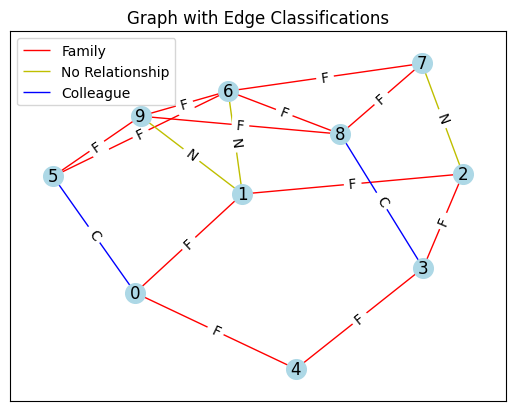

In [ ]:
G_hardcoded = create_hardcoded_graph()
plot_graph(G_hardcoded)
train_edges, test_edges = custom_train_test_split(G_hardcoded, test_size=0.2, random_state=42)

In [ ]:
# edges = G_hardcoded.edges(data=True)
# for edge in edges:
#     print(edge)

In [ ]:
# Assuming you already have the embeddings (e.g., using DeepWalk or Node2Vec)
embeddings = node_embedding_feature_extraction(G_hardcoded)

# Train and test the model
trained_model = train_model(G_hardcoded, embeddings, train_edges, test_edges)

Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Test Accuracy: 0.21052631578947367


In [ ]:
def predict_relationship_between_nodes(model, embeddings, node1, node2):
    # Obtain node embeddings
    embedding1 = embeddings[node1]
    embedding2 = embeddings[node2]

    # Concatenate the embeddings
    features = np.concatenate([embedding1, embedding2]).reshape(1, -1)

    # Predict the relationship using the trained model
    relationship_prob = model.predict_proba(features)[0]

    return relationship_prob

In [ ]:
node1 = 6
node2 = 7

relationship_prob = predict_relationship_between_nodes(trained_model, embeddings, node1, node2)
print(f"Probability of Family relationship: {relationship_prob[2]:.2f}")
print(f"Probability of Colleague relationship: {relationship_prob[1]:.2f}")
print(f"Probability of No relationship: {relationship_prob[0]:.2f}")
# if(relationship_prob[0]>0.29):
#   print("Colleague Relationship")
# else:
#   print("Family Relationship")

Probability of Family relationship: 0.07
Probability of Colleague relationship: 0.58
Probability of No relationship: 0.35


In [ ]:
embedding_1 = embeddings[1]
embedding_4 = embeddings[2]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Reshape embeddings for sklearn cosine_similarity function
embedding_1_reshaped = embedding_1.reshape(1, -1)
embedding_4_reshaped = embedding_4.reshape(1, -1)

# Calculate cosine similarity
cosine_sim = cosine_similarity(embedding_1_reshaped, embedding_4_reshaped)[0][0]

print(f"Cosine Similarity between Node 6 and Node 7: {cosine_sim:.4f}")


Cosine Similarity between Node 6 and Node 7: 0.0117


In [ ]:
G = nx.Graph()
no_of_families=2
n=no_of_families*5
# family_nodes1 = [i for i in range(0,5)]
# G.add_edges_from([(i, (i + 1) % 5, {'relationship': 'family'}) for i in family_nodes1])
# family_nodes2 = [i for i in range(5,10)]
# G.add_edges_from([(i, (i + 1) % 5 + 5, {'relationship': 'family'}) for i in family_nodes2])
for i in range(0,n,5):
  G.add_edges_from([(j, (j + 1) % 5+i, {'relationship': 'F'}) for j in range(i,i+5)])
for i in range(0,n-5,5):
  G.add_edges_from([(j,  j+ 5, {'relationship': 'N'}) for j in range(i,i+4)])

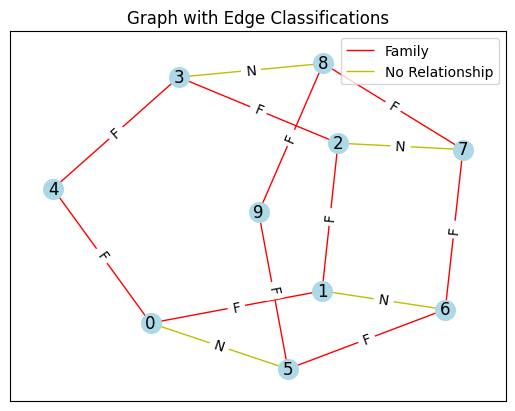

In [ ]:
plot_graph(G)

In [ ]:
# Assuming you already have the embeddings for G_hardcoded
embeddings_hardcoded = node_embedding_feature_extraction(G_hardcoded)

# Train the model on G_hardcoded
trained_model_hardcoded = train_model(G_hardcoded, embeddings_hardcoded, train_edges, test_edges)


Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Obtain embeddings for nodes in G using the same Node2Vec model
embeddings_G = node_embedding_feature_extraction(G)

# Predict relationship between nodes 4 and 9 in graph G using the trained model on G_hardcoded
node1_G = 4
node2_G = 9
relationship_prob_G = predict_relationship_between_nodes(trained_model_hardcoded, embeddings_G, node1_G, node2_G)

# Display the predicted probabilities for G
print(f"Probability of Family relationship: {relationship_prob_G[2]:.2f}")
print(f"Probability of Colleague relationship: {relationship_prob_G[1]:.2f}")
print(f"Probability of No relationship: {relationship_prob_G[0]:.2f}")